In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn, optim

In [2]:
%matplotlib inline

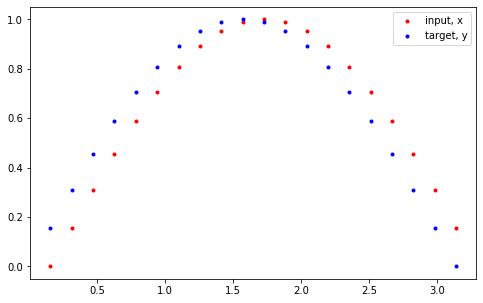

In [3]:
plt.figure(figsize=(8, 5))
seq_length = 20

time_steps = np.linspace(0, np.pi, seq_length + 1)
data = np.sin(time_steps)
data.resize(seq_length + 1, 1)

x = data[:-1]
y = data[1:]

plt.plot(time_steps[1:], x, "r.", label="input, x")
plt.plot(time_steps[1:], y, "b.", label="target, y")
plt.legend()
plt.show()

### Implement RNN

In [4]:
class RNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        super(RNN, self).__init__()
        self.hidden_dim = hidden_dim
        # batch_size -> first dimension of input & output will be the batch_size
        self.rnn = nn.RNN(input_size, hidden_dim, n_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_size)
    
    def forward(self, x, hidden):
        """
        param:
        x -> (batch_size, seq_length, input_size)
        hidden -> (n_layers, batch_size, hidden_size)
        r_out -> (batch_size, time_step, hidden_size)
        """
        batch_size = x.size(0)
        r_out, hidden = self.rnn(x, hidden)
        r_out = r_out.view(-1, self.hidden_dim)
        output = self.fc(r_out)
        return output, hidden

In [5]:
# hyperparameters
input_size = 1
output_size = 1
hidden_dim = 32
n_layers = 1

In [6]:
# instantiate RNN
rnn = RNN(input_size, output_size, hidden_dim, n_layers)
rnn

RNN(
  (rnn): RNN(1, 32, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)

In [7]:
# loss and optimization
criterion = nn.MSELoss()
optimizer = optim.Adam(rnn.parameters(), lr=0.01)

In [10]:
# training the network

def train(rnn, n_steps, print_every):
    hidden = None
    
    for batch_i, step in enumerate(range(n_steps)):
        time_steps = np.linspace(step*np.pi, (step+1)*np.pi, seq_length + 1)
        data = np.sin(time_steps)
        data.resize(seq_length+1, 1)
        
        x = data[:-1]
        y = data[1:]
        
        x_tensor = torch.Tensor(x).unsqueeze(0)
        y_tensor = torch.Tensor(y)
        
        prediction, hidden = rnn(x_tensor, hidden)
        
        # represents memory
        hidden = hidden.data
        
        # calculate loss
        loss = criterion(prediction, y_tensor)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch_i % print_every == 0:
            print("Loss : {}".format(loss.item()))
            plt.plot(time_steps[1:], x, "r.")
            plt.plot(time_steps[1:], prediction.data.numpy().flatten(), "b.")
            plt.show()
            
    return rnn

Loss : 0.003283378202468157


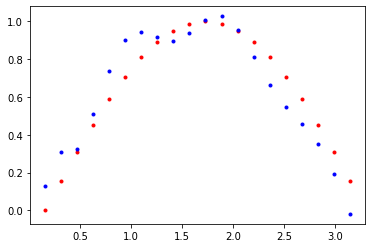

Loss : 0.00016414572019129992


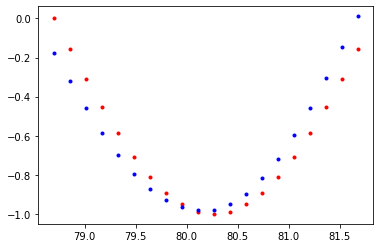

Loss : 0.00014697625010740012


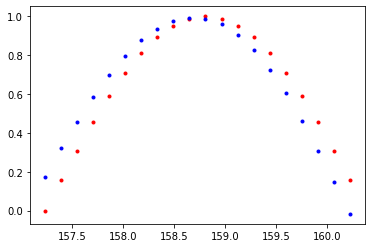

Loss : 0.0001098415013984777


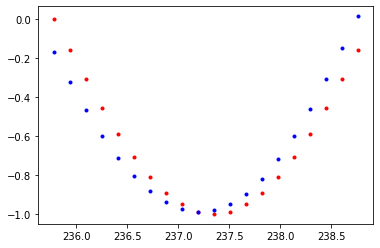

In [12]:
n_steps = 100
print_every = 25

trained_rnn = train(rnn, n_steps, print_every)